In [32]:
import pandas as pd
import numpy as np
import jinja2
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats import poisson
import datetime

## Preprocessing BL

In [61]:
path_bundesliga = r"preprocessed_dataframe_with_elo_1.csv"
match_data_unfiltered = pd.read_csv(path_bundesliga, delimiter=",")
match_data_unfiltered.tail()
# match_data_unfiltered.info()
pd.to_datetime('30.06.2021')

Timestamp('2021-06-30 00:00:00')

In [62]:
match_data_unfiltered['Date'] = pd.to_datetime(match_data_unfiltered['Date'])
match_data_unfiltered = match_data_unfiltered.drop(["Unnamed: 0"], axis=1, errors="ignore")
# print(match_data_unfiltered.columns)
match_data_unfiltered.tail(n=5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
4891,2022-05-14,Mainz,Ein Frankfurt,2.0,2.0,D,1.0,2.0,A,13.0,...,2.001489,-1.884149,1.172358,-1.581157,1.868412,-1.545160,0.652603,-1.330148,849.372072,844.265646
4892,2022-05-14,M'gladbach,Hoffenheim,5.0,1.0,H,3.0,1.0,H,19.0,...,3.347095,-1.133621,1.647127,-4.249006,2.048918,-1.426219,2.062127,-3.467829,877.665071,855.590835
4893,2022-05-14,Stuttgart,FC Koln,2.0,1.0,H,1.0,0.0,H,24.0,...,1.491069,-1.100222,1.535998,-1.369941,0.963734,-1.335884,1.877641,-0.890119,734.655957,762.003692
4894,2022-05-14,Union Berlin,Bochum,3.0,2.0,H,2.0,0.0,H,17.0,...,2.870488,-1.234870,1.944127,-2.321089,2.570349,-0.727307,1.757577,-1.887840,746.240131,389.650242
4895,2022-05-14,Wolfsburg,Bayern Munich,2.0,2.0,D,1.0,2.0,A,10.0,...,1.994849,-1.248584,2.255671,-1.869960,1.949939,-0.849493,2.258790,-1.790906,825.333792,1118.372385


In [63]:
match_data_unfiltered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           4896 non-null   datetime64[ns]
 1   HomeTeam       4896 non-null   object        
 2   AwayTeam       4896 non-null   object        
 3   FTHG           4896 non-null   float64       
 4   FTAG           4896 non-null   float64       
 5   FTR            4896 non-null   object        
 6   HTHG           4896 non-null   float64       
 7   HTAG           4896 non-null   float64       
 8   HTR            4896 non-null   object        
 9   HS             4896 non-null   float64       
 10  AS             4896 non-null   float64       
 11  HST            4896 non-null   float64       
 12  AST            4896 non-null   float64       
 13  HF             4896 non-null   float64       
 14  AF             4896 non-null   float64       
 15  HC             4896 n

In [36]:
df_test = match_data_unfiltered[match_data_unfiltered['Date'] > pd.to_datetime('2021-06-30')]
match_data_unfiltered = match_data_unfiltered[(match_data_unfiltered.Date < pd.to_datetime('2021-06-30'))&(match_data_unfiltered.Date > pd.to_datetime('2015-06-30'))]
df_test

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
4410,2021-08-01,M'gladbach,Bayern Munich,3.0,2.0,H,2.0,2.0,D,8.0,...,2.240069,-1.371492,3.223870,-2.187781,1.493803,-1.360885,3.832490,-1.548463,857.598611,1073.187392
4411,2021-09-01,Freiburg,FC Koln,5.0,0.0,H,2.0,0.0,H,12.0,...,4.289963,-0.526902,-0.004429,-2.715384,3.104461,-0.862702,0.098294,-1.202607,764.861819,639.193632
4412,2021-09-01,Leverkusen,Werder Bremen,1.0,1.0,D,0.0,0.0,D,12.0,...,1.562984,-1.244477,0.534236,-1.327875,2.028214,-1.251897,0.303673,-1.637197,868.568978,649.742041
4413,2021-09-01,Mainz,Ein Frankfurt,0.0,2.0,A,0.0,1.0,A,8.0,...,0.337272,-2.347070,2.104636,-0.595728,0.743759,-2.602679,2.236832,-1.020619,661.989255,821.574041
4414,2021-09-01,Schalke 04,Hoffenheim,4.0,0.0,H,1.0,0.0,H,12.0,...,1.672543,-1.465030,0.611713,-3.064203,-0.116485,-2.598398,1.271747,-2.037234,657.727602,781.556074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2022-05-14,Mainz,Ein Frankfurt,2.0,2.0,D,1.0,2.0,A,13.0,...,2.001489,-1.884149,1.172358,-1.581157,1.868412,-1.545160,0.652603,-1.330148,849.372072,844.265646
4892,2022-05-14,M'gladbach,Hoffenheim,5.0,1.0,H,3.0,1.0,H,19.0,...,3.347095,-1.133621,1.647127,-4.249006,2.048918,-1.426219,2.062127,-3.467829,877.665071,855.590835
4893,2022-05-14,Stuttgart,FC Koln,2.0,1.0,H,1.0,0.0,H,24.0,...,1.491069,-1.100222,1.535998,-1.369941,0.963734,-1.335884,1.877641,-0.890119,734.655957,762.003692
4894,2022-05-14,Union Berlin,Bochum,3.0,2.0,H,2.0,0.0,H,17.0,...,2.870488,-1.234870,1.944127,-2.321089,2.570349,-0.727307,1.757577,-1.887840,746.240131,389.650242


## Preprocessing PL

In [37]:
# read the csv file
path = r"C:\Users\Phili\Desktop\Data Exploration Project\EPL_Test_Repo\DataScienceProjects\data\history.csv"
# path = "preprocessed_dataframe_with_elo_1.csv"
match_data_unfiltered = pd.read_csv(path)

In [38]:
match_data_unfiltered = match_data_unfiltered[match_data_unfiltered['Season'].str.contains('201')]
match_data_unfiltered

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
6624,E0,14/08/10,Aston Villa,West Ham,3,0,H,2.0,0.0,H,2010-11
6625,E0,14/08/10,Blackburn,Everton,1,0,H,1.0,0.0,H,2010-11
6626,E0,14/08/10,Bolton,Fulham,0,0,D,0.0,0.0,D,2010-11
6627,E0,14/08/10,Chelsea,West Brom,6,0,H,2.0,0.0,H,2010-11
6628,E0,14/08/10,Sunderland,Birmingham,2,2,D,1.0,0.0,H,2010-11
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


In [39]:
# split train test data
# df_train = match_data_unfiltered[match_data_unfiltered.reset_index().index % 3 != 0]  # Excludes every 3rd row starting from 0
# df_test = match_data_unfiltered[match_data_unfiltered.reset_index().index % 3 == 0]  # Selects every 3rd row starting from 0
# match_data_unfiltered = df_train
# df_test = match_data_unfiltered[match_data_unfiltered['Season']=='2017-18']
# match_data_unfiltered = match_data_unfiltered[(match_data_unfiltered['Season'].str.contains('201'))&(match_data_unfiltered['Season']!='2017-18')]
df_test = match_data_unfiltered.iloc[-100:, :]
match_data_unfiltered = match_data_unfiltered.iloc[:-100,:]
df_test


,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
9564,E0,3/3/2018,Burnley,Everton,2,1,H,0.0,1.0,A,2017-18
9565,E0,3/3/2018,Leicester,Bournemouth,1,1,D,0.0,1.0,A,2017-18
9566,E0,3/3/2018,Liverpool,Newcastle,2,0,H,1.0,0.0,H,2017-18
9567,E0,3/3/2018,Southampton,Stoke,0,0,D,0.0,0.0,D,2017-18
9568,E0,3/3/2018,Swansea,West Ham,4,1,H,2.0,0.0,H,2017-18
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


In [40]:
df_test

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
9564,E0,3/3/2018,Burnley,Everton,2,1,H,0.0,1.0,A,2017-18
9565,E0,3/3/2018,Leicester,Bournemouth,1,1,D,0.0,1.0,A,2017-18
9566,E0,3/3/2018,Liverpool,Newcastle,2,0,H,1.0,0.0,H,2017-18
9567,E0,3/3/2018,Southampton,Stoke,0,0,D,0.0,0.0,D,2017-18
9568,E0,3/3/2018,Swansea,West Ham,4,1,H,2.0,0.0,H,2017-18
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


## Data Knowledge

In [59]:
# winning_team

winning_team = match_data_unfiltered['FTR'].value_counts()
print(f"Gewinnchancen \nHome Team: {winning_team['H']/winning_team.sum()}")
print(f"Away Team: {winning_team['A']/winning_team.sum()}")
print(f"Draw: {winning_team['D']/winning_team.sum()}")

Gewinnchancen 
Home Team: 0.45510204081632655
Away Team: 0.2894557823129252
Draw: 0.25544217687074827


In [60]:
# How good are the bookies (BWIN)

match_data_unfiltered['B365H']



KeyError: 'B365H'

## Modeltraining 

In [42]:
# make FTR column to continous variable
# def convert_ftr(result: str):
#     if result == "D":
#         return 2
#     elif result == "H":
#         return 3
#     elif result == "A":
#         return 1
#     else: 
#         return None
# match_data_unfiltered['FTR'] = match_data_unfiltered['FTR'].apply(convert_ftr)

In [43]:
# [match_data_unfiltered['Season'].str.contains('201')]

max prob mit einem Testdatensatz von 50: 58% 
komplette halbe Saison: 64%

In [44]:
# print correlation matrix
correlation_matrix_match_data_unfiltered = match_data_unfiltered.corr()
correlation_matrix_match_data_unfiltered.style.background_gradient()

,FTHG,FTAG,HTHG,HTAG
FTHG,1.000000,-0.070148,0.683493,-0.061623
FTAG,-0.070148,1.000000,-0.077605,0.693197
HTHG,0.683493,-0.077605,1.000000,-0.073274
HTAG,-0.061623,0.693197,-0.073274,1.000000


In [45]:
history_pair_h = match_data_unfiltered.groupby(['HomeTeam', 'AwayTeam'])
ave_home_scored = history_pair_h['FTHG'].mean()
history_pair_a = match_data_unfiltered.groupby(['AwayTeam', 'HomeTeam'])
ave_away_scored = history_pair_a['FTAG'].mean()

ave_away_scored.keys()
ave_away_scored

AwayTeam  HomeTeam   
Arsenal   Aston Villa    2.166667
          Birmingham     3.000000
          Blackburn      2.500000
          Blackpool      3.000000
          Bolton         0.500000
                           ...   
Wolves    Swansea        4.000000
          Tottenham      1.000000
          West Brom      0.500000
          West Ham       0.000000
          Wigan          1.000000
Name: FTAG, Length: 931, dtype: float64

## Verbesserungen:
- nur direkten Vergleich nehmen, wenn Mannschaften mind. 5x gegeneinander gespielt haben
- immer alle Werte miteinbeziehen --> Testen ob besser
- Testen der Features mit ML
- Naive Bayes oder anderen ML (Poisson Regression Model) verwenden und Possion Verteilung verwenden

In [46]:
home_test = ave_home_scored.index[0][0]
away_test = ave_home_scored.index[0][1]
print(home_test)
t_ave_h_scored = ave_home_scored.loc[home_test].mean()
t_ave_h_scored

Arsenal


2.325665266106443

In [47]:
def get_score(home, away, nsim):
    result = []
    try:
        ave_h_scored = ave_home_scored.loc[home, away]#, ave_away_scored.loc(away)}
        ave_a_scored = ave_away_scored.loc[away, home]
        for i in range(nsim):
            h_scored = poisson.rvs(1, ave_h_scored)
            a_scored = poisson.rvs(1, ave_a_scored)
            result.append([h_scored, a_scored])
        return result

    except:
        # try:
        t_ave_h_scored = ave_home_scored.loc[home].mean()
        t_ave_h_conceded = ave_away_scored.loc[:, home].mean()
        t_ave_a_scored = ave_away_scored.loc[away].mean()
        t_ave_a_conceded = ave_home_scored.loc[:, away].mean()
        # except:
        #     return []

        for i in range(nsim):
            h_scored = poisson.rvs(1, (t_ave_h_scored+t_ave_a_conceded)/2)
            a_scored = poisson.rvs(1, (t_ave_a_scored+t_ave_h_conceded)/2)
            result.append([h_scored, a_scored])
        return result

    # return ave_h_scored, ave_a_scored
score_arsenal_wh = get_score(home_test, away_test, 1000)

In [48]:
# result = pd.DataFrame(columns=["Winner"])
alpha = 0.04
number_of_repetitions = 10000

def get_result_for_one_single_match(home_team, away_team):
    result = []
    x = get_score(home_team, away_team, number_of_repetitions)
    for i in x:
        if i[0] > i[1]:
            result.append('H')
        elif i[0] == i[1]:
            result.append('D')
        else:
            result.append('A')
    # if x == []:
    #     return None
    home_win = result.count('H')/len(result)
    away_win = result.count('A')/len(result)
    draw = result.count('D')/len(result)
    print(f"Probability for home win: {home_win}, Away_win: {away_win}, draw: {draw}, Teams: {home_team, away_team}")
    return 'H' if home_win > away_win and home_win > (draw+alpha) else 'A' if away_win > (draw+alpha) else 'D' 

In [49]:
df_test['PredictedResult'] = None
# df_test[]
# df_test = df_test.tail(n=100)
for i in df_test.index:
    home_team = df_test['HomeTeam'][i]
    away_team = df_test['AwayTeam'][i]
    df_test['PredictedResult'][i] = get_result_for_one_single_match(home_team, away_team)

c:\Users\Phili\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Probability for home win: 0.1319, Away_win: 0.6548, draw: 0.2133, Teams: ('Burnley', 'Everton')


C:\Users\Phili\AppData\Local\Temp/ipykernel_1568/1684315969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['PredictedResult'][i] = get_result_for_one_single_match(home_team, away_team)


Probability for home win: 0.3439, Away_win: 0.3477, draw: 0.3084, Teams: ('Leicester', 'Bournemouth')
Probability for home win: 0.8642, Away_win: 0.0394, draw: 0.0964, Teams: ('Liverpool', 'Newcastle')
Probability for home win: 0.1307, Away_win: 0.6529, draw: 0.2164, Teams: ('Southampton', 'Stoke')
Probability for home win: 0.3372, Away_win: 0.3448, draw: 0.318, Teams: ('Swansea', 'West Ham')
Probability for home win: 0.6539, Away_win: 0.1281, draw: 0.218, Teams: ('Tottenham', 'Huddersfield')
Probability for home win: 0.6512, Away_win: 0.1338, draw: 0.215, Teams: ('Watford', 'West Brom')
Probability for home win: 0.3407, Away_win: 0.3495, draw: 0.3098, Teams: ('Brighton', 'Arsenal')
Probability for home win: 0.6532, Away_win: 0.1284, draw: 0.2184, Teams: ('Man City', 'Chelsea')
Probability for home win: 0.1305, Away_win: 0.6587, draw: 0.2108, Teams: ('Crystal Palace', 'Man United')
Probability for home win: 0.3543, Away_win: 0.3372, draw: 0.3085, Teams: ('Chelsea', 'Crystal Palace')
Pr

In [50]:
# df_test['True'] = df_test[df_test['FTR']==df_test['PredictedResult']]
# df_test['True'].count_values()

In [51]:
# df_test = df_test.dropna()
len(df_test[df_test['FTR']==df_test['PredictedResult']])/len(df_test)

0.51

In [52]:
df_test['FTR'].value_counts()

H    46
A    32
D    22
Name: FTR, dtype: int64

In [53]:
df_test['PredictedResult'].value_counts()

H    59
A    26
D    15
Name: PredictedResult, dtype: int64

# Evaluation:
- Vergleich mit Wettanbierter --> Gewinn?

In [54]:
df_test.to_csv("predicted_season_17-18_PL.csv")

In [55]:
# filter for specific columns
# match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeElo", "AwayElo", "HomeAttack", "HomeDefend", "AwayAttack", "AwayDefend"]]
# "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    # "AwayAttackOld", "AwayDefendOld"
# print correlation matrix
match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld", "AwayAttackOld", "AwayDefendOld"]]

correlation_matrix_match_data_reduced = match_data_reduced.corr()
correlation_matrix_match_data_reduced.style.background_gradient()

KeyError: "['HomeEloOld', 'AwayEloOld', 'HomeAttackOld', 'HomeDefendOld', 'AwayAttackOld', 'AwayDefendOld'] not in index"

In [ ]:
X = match_data_unfiltered.loc[:, ["HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    "AwayAttackOld", "AwayDefendOld"
]]

# use full time home goals and full time away goals; alternatively also using result directly is possible
y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train, y_train = X, y

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
# clf.predict(X_test)

In [ ]:
# result = clf.score(X_test, y_test)

In [ ]:
# result

In [ ]:
# class_names = {
#     'Away'
#     ,'Draw',
#     'Home'
# }
# # Plot non-normalized confusion matrix
# titles_options = [
#     ("Confusion matrix, without normalization", None),
#     ("Normalized confusion matrix", "true"),
# ]
# for title, normalize in titles_options:
#     disp = ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         #display_labels=class_names,
#         cmap=plt.cm.Blues,
#         normalize=normalize,
#     )
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend, callbacks
#create model
model = Sequential()

#get number of columns in training data
n_cols_2 = X_train.shape[1]
print(n_cols_2)

#add layers to model
model.add(Dense(10, activation='relu', input_shape=(n_cols_2, )))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], metrics=['accuracy'])
model.compile(metrics=['accuracy'], optimizer='rmsprop', 
              loss='categorical_crossentropy')
# K.set_value(model.optimizer.learning_rate, 0.01)

# early_stopping_monitor = EarlyStopping(patience=3)

es = callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) 


history = model.fit(X_train, y_train,  epochs=30, batch_size = 500, validation_split=0.3) #, callbacks=[early_stopping_monitor]) #callbacks=[es],

6
Epoch 1/30
2/2 [==============================] - 1s 150ms/step - loss: 81.7261 - accuracy: 0.3318 - val_loss: 37.3216 - val_accuracy: 0.3432
Epoch 2/30
2/2 [==============================] - 0s 23ms/step - loss: 24.7020 - accuracy: 0.3805 - val_loss: 12.6204 - val_accuracy: 0.6216
Epoch 3/30
2/2 [==============================] - 0s 22ms/step - loss: 11.3287 - accuracy: 0.5673 - val_loss: 10.8836 - val_accuracy: 0.6622
Epoch 4/30
2/2 [==============================] - 0s 25ms/step - loss: 9.4702 - accuracy: 0.6114 - val_loss: 8.2082 - val_accuracy: 0.6459
Epoch 5/30
2/2 [==============================] - 0s 24ms/step - loss: 7.3085 - accuracy: 0.6067 - val_loss: 6.1327 - val_accuracy: 0.6568
Epoch 6/30
2/2 [==============================] - 0s 21ms/step - loss: 5.9087 - accuracy: 0.5824 - val_loss: 9.2343 - val_accuracy: 0.6946
Epoch 7/30
2/2 [==============================] - 0s 23ms/step - loss: 9.1395 - accuracy: 0.5383 - val_loss: 11.6878 - val_accuracy: 0.6946
Epoch 8/30
2/2 [=

In [ ]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 1ms/step - loss: 10.2801 - accuracy: 0.5980


[10.280076026916504, 0.5980230569839478]

In [ ]:
test = model.predict(X_test)
winning_team = []
for item in test:
    if abs(item[0]-item[1]) < 0.5:
        winning_team.append(2)
    elif item[0] > item[1]:
        winning_team.append(3)
    else:
        winning_team.append(1)
#   if result == "D":
#         return 2
#     elif result == "H":
#         return 3
#     elif result == "A":
#         return 1
winning_team.count(2)

46

In [ ]:
winning_team_test = []
for item in np.array(y_test):
    if item[0] > item[1]:
        winning_team_test.append(3)
    elif item[0] == item[1]:
        winning_team_test.append(2)
    else:
        winning_team_test.append(1)
len(winning_team)

607

In [ ]:
y_test
test

array([[9.9998772e-01, 1.2314160e-05],
       [9.9999583e-01, 4.2045735e-06],
       [9.7026283e-01, 2.9737191e-02],
       ...,
       [8.1977919e-02, 9.1802210e-01],
       [9.9912447e-01, 8.7551231e-04],
       [1.0166747e-01, 8.9833260e-01]], dtype=float32)

In [ ]:
counter = 0
for i in range(len(winning_team)):
    if winning_team[i] == winning_team_test[i]:
        counter += 1
counter/len(winning_team)

0.42504118616144976

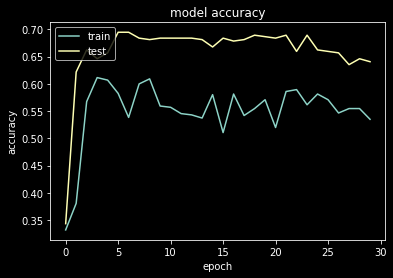

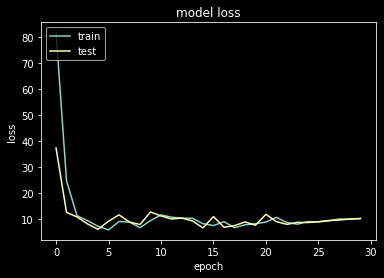

In [ ]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()